# Literature Search

Here we will explore the prevalence of different measures of aperiodic activity in the literature.

To do so, we will use [LISC](https://github.com/lisc-tools/lisc), a Python module for collecting and analyzing scientific literature. More information on LISC can be found in the [documentation](https://lisc-tools.github.io/lisc/).

To explore the prevalence and use cases of aperiodic measures, we will collect information from the Pubmed database on the number of papers that include search terms mentioning aperiodic activity and measures, as well as the number of papers that mention these terms of interest in co-occurrence with specified association terms.

Note that collecting literature data in this way is likely an under-estimate of the use of these measures, as the approach employed here only searches for search terms occurring in abstracts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import LISC code
from lisc import Counts
from lisc.utils import save_object, load_object
from lisc.plts.counts import plot_matrix, plot_vector

In [3]:
# # Import custom code
# import sys; from pathlib import Path
# sys.path.append(str(Path('..').resolve()))
# from apm.core.db import APMDB

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

First, we will define some settings for the literature collection.

In [5]:
# Settings for literature collection
db = 'pubmed'
#db = 'pmc'

In [6]:
# Notebook settings
RUN_COLLECTION = True
SAVE_FIG = False
SAVE_DATA = False

## Define Terms

Here we will define search terms to use to collect information on the literature of interest. 

### Search Terms

First, we will define the search terms that reflect our terms of interest.

Note that each set of terms within a list is a defined as a set of synonyms

In [7]:
# Set list of aperiodic terms
ap_terms = [['1/f', 'aperiodic'],
            ['entropy'],
            ['autocorrelation'],
            ['fractal', 'scale free'],
            ['criticality'],
            ['dfa', 'detrended fluctuation analysis'],
           ]

# # Set list of aperiodic methods
# ap_methods = [['spectral parameterization', 'fooof'], 
#               ['irasa', 'cgsa'],
#               ['fractal exponent', 'higuchi', 'katz', 'petrosian'], 
#               ['entropy']
#              ]

### Inclusion / Exclusion Terms

In some cases, we might want to use additional search terms to explicit include or exclude results that contain particular terms. 

These terms can be used to restrict searches to literature of interest, excluding irrelevant literature. 

In [8]:
# Set inclusion / exclusion terms
inclusions = ['EEG', 'electroencephalography', 'MEG', 'magnetoencephalography', 
              'ECoG', 'electrocorticography', 'iEEG', 'intracranial EEG',
              'LFP', 'local field potential']
ap_inclusions = [inclusions] * len(ap_terms)

In [9]:
# Define a list of association terms
assoc_terms = [['aging', 'development'],
               ['cognitive', 'cognition', 'task', 'behavior'],
               ['sleep', 'anesthesia'],
               ['clinical', 'disease', 'disorder']
              ]

## Add & Check Terms

Now we can add these terms to LISC objects, ready for data collection. 

In [10]:
# Initialize counts object
counts = Counts()

In [11]:
# Add terms to the LISC object
counts.add_terms(ap_terms)
counts.add_terms(ap_inclusions, term_type='inclusions')
counts.add_terms(assoc_terms, dim='B')

In [12]:
# Check terms
counts.terms['A'].check_terms()

List of terms used: 

1/f              : 1/f, aperiodic
entropy          : entropy
autocorrelation  : autocorrelation
fractal          : fractal, scale free
criticality      : criticality
dfa              : dfa, detrended fluctuation analysis


In [13]:
# Check terms
counts.terms['B'].check_terms()

List of terms used: 

aging      : aging, development
cognitive  : cognitive, cognition, task, behavior
sleep      : sleep, anesthesia
clinical   : clinical, disease, disorder


## Collect Literature Data

Run literature collection. 

In [14]:
# Run the data collection
if RUN_COLLECTION:
    counts.run_collection(db=db)
else:
    counts = load_object('aps_counts.p', directory=dp.literature)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


## Check and Process Collected Data

Now we can examine the collected literature data.

In [15]:
# Check how many papers were found for each ratio search term
counts.check_counts()

The number of documents found for each search term is:
  '1/f'               -    331
  'entropy'           -   1972
  'autocorrelation'   -    162
  'fractal'           -    502
  'criticality'       -    107
  'dfa'               -    171


In [16]:
# Check the total number of papers across all ratio terms
n_total = sum(counts.terms['A'].counts)
print('Total number of aperiodic measure papers is: \t', n_total)

Total number of aperiodic measure papers is: 	 3245


In [17]:
# Normalize the association results
counts.compute_score('normalize', dim='A')

## Create Visualizations of Collected Data

In [18]:
# Set adapted versions of the labels to use for plots
#ap_labels = ['specparam', 'irasa', 'entropy', 'ac', 'f-exp', 'dfa']
#assoc_labels = ['aging', 'cognition', 'state', 'clinical']

ap_labels = counts.terms['A'].labels
assoc_labels = counts.terms['B'].labels

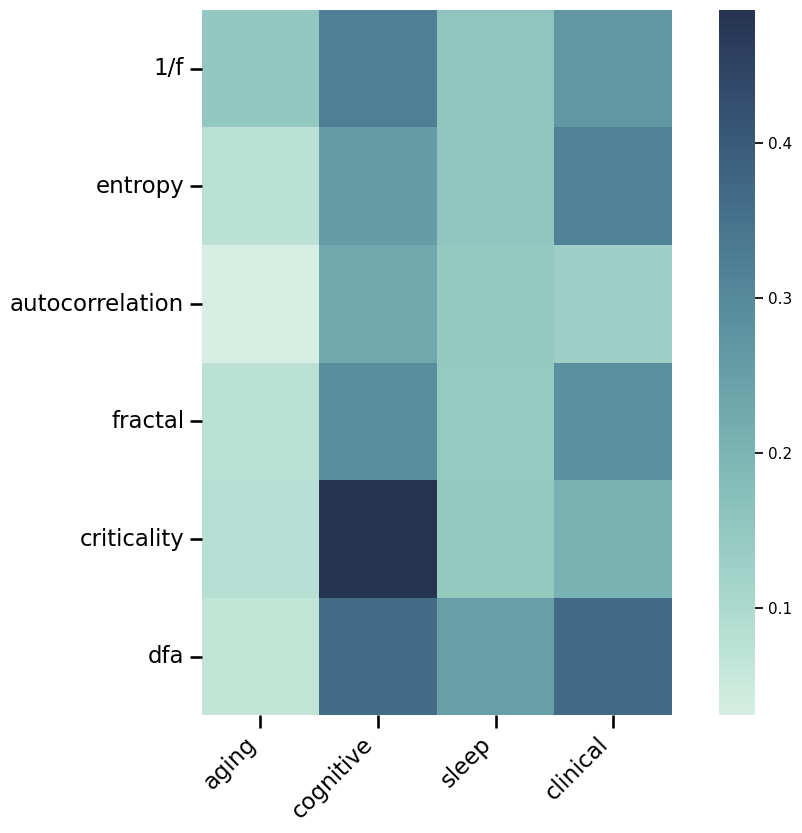

In [19]:
# Plot the associations of aperiodic measures in the literature
fig, ax = plt.subplots(figsize=(10, 8))
plot_matrix(counts.score, assoc_labels, ap_labels, cmap='blue', square=True, ax=ax)
plt.xticks(rotation=45, horizontalalignment='right');
if SAVE_FIG: plt.savefig(fp.make_file_path(fp.literature, 'AP-Associations', 'pdf'))

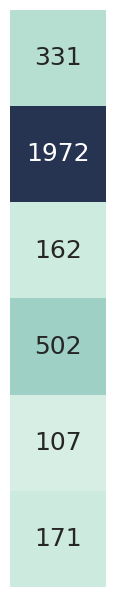

In [20]:
# Plot the number of papers found per ratio measure
plot_vector(counts, cmap='blue', figsize=(2.5, 7.5))
if SAVE_FIG: plt.savefig(fp.make_file_path(fp.literature, 'AP-Counts', 'pdf'))

In [21]:
# Save out the collected data
#if SAVE_DATA:
#    save_object(counts, 'aps_counts', directory=dp.literature)